In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Create spark session
spark = SparkSession.builder.appName("nba-stats").getOrCreate()
spark

In [3]:
# Location of the ratings.csv  file
CSV_LOCATION = "archive/nba_stats_1950_2022.csv"

In [4]:
# Read the dataset
df = spark.read.csv(CSV_LOCATION, header=True, inferSchema=True)

In [5]:
df.printSchema()

root
 |-- Rk: integer (nullable = true)
 |-- Player: string (nullable = true)
 |-- Pos: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tm: string (nullable = true)
 |-- G: integer (nullable = true)
 |-- GS: integer (nullable = true)
 |-- MP: double (nullable = true)
 |-- FG: double (nullable = true)
 |-- FGA: double (nullable = true)
 |-- FG%: double (nullable = true)
 |-- 3P: double (nullable = true)
 |-- 3PA: double (nullable = true)
 |-- 3P%: double (nullable = true)
 |-- 2P: double (nullable = true)
 |-- 2PA: double (nullable = true)
 |-- 2P%: double (nullable = true)
 |-- eFG%: double (nullable = true)
 |-- FT: double (nullable = true)
 |-- FTA: double (nullable = true)
 |-- FT%: double (nullable = true)
 |-- ORB: double (nullable = true)
 |-- DRB: double (nullable = true)
 |-- TRB: double (nullable = true)
 |-- AST: double (nullable = true)
 |-- STL: double (nullable = true)
 |-- BLK: double (nullable = true)
 |-- TOV: double (nullable = true)
 |-- PF: double (

In [6]:
df.show(5)
df.describe().show()
df.select(["Player"]).show(5)

+---+---------------+---+---+---+---+----+----+---+---+-----+----+----+----+---+---+-----+-----+---+---+-----+----+----+----+---+----+----+----+---+---+----+
| Rk|         Player|Pos|Age| Tm|  G|  GS|  MP| FG|FGA|  FG%|  3P| 3PA| 3P%| 2P|2PA|  2P%| eFG%| FT|FTA|  FT%| ORB| DRB| TRB|AST| STL| BLK| TOV| PF|PTS|Year|
+---+---------------+---+---+---+---+----+----+---+---+-----+----+----+----+---+---+-----+-----+---+---+-----+----+----+----+---+----+----+----+---+---+----+
|  1|Curly Armstrong|G-F| 31|FTW| 63|null|null|2.3|8.2|0.279|null|null|null|2.3|8.2|0.279|0.279|2.7|3.8|0.705|null|null|null|2.8|null|null|null|3.4|7.3|1950|
|  2|   Cliff Barker| SG| 29|INO| 49|null|null|2.1|5.6|0.372|null|null|null|2.1|5.6|0.372|0.372|1.5|2.2|0.708|null|null|null|2.2|null|null|null|2.0|5.7|1950|
|  3|  Leo Barnhorst| SF| 25|CHS| 67|null|null|2.6|7.4|0.349|null|null|null|2.6|7.4|0.349|0.349|1.3|1.9|0.698|null|null|null|2.1|null|null|null|2.9|6.5|1950|
|  4|     Ed Bartels|  F| 24|TOT| 15|null|null|1.5|5

In [7]:
# Filter out the TOT records into a separate DataFrame
tot_df = df.filter(df["Tm"] == "TOT")
# Get the non-TOT records into another DataFrame
non_tot_df = df.filter(df["Tm"] != "TOT")
# Now, remove players from the non-TOT DataFrame that appear in the TOT DataFrame
clean_non_tot_df = non_tot_df.join(tot_df, ["Player", "Year"], "left_anti")

In [8]:
# Union the TOT and cleaned non-TOT DataFrames
final_df = tot_df.unionByName(clean_non_tot_df).orderBy(F.asc("Year"),F.asc("Rk"))
final_df.show()

+---+----------------+---+---+---+---+----+----+---+----+-----+----+----+----+---+----+-----+-----+---+---+-----+----+----+----+---+----+----+----+---+----+----+
| Rk|          Player|Pos|Age| Tm|  G|  GS|  MP| FG| FGA|  FG%|  3P| 3PA| 3P%| 2P| 2PA|  2P%| eFG%| FT|FTA|  FT%| ORB| DRB| TRB|AST| STL| BLK| TOV| PF| PTS|Year|
+---+----------------+---+---+---+---+----+----+---+----+-----+----+----+----+---+----+-----+-----+---+---+-----+----+----+----+---+----+----+----+---+----+----+
|  1| Curly Armstrong|G-F| 31|FTW| 63|null|null|2.3| 8.2|0.279|null|null|null|2.3| 8.2|0.279|0.279|2.7|3.8|0.705|null|null|null|2.8|null|null|null|3.4| 7.3|1950|
|  2|    Cliff Barker| SG| 29|INO| 49|null|null|2.1| 5.6|0.372|null|null|null|2.1| 5.6|0.372|0.372|1.5|2.2|0.708|null|null|null|2.2|null|null|null|2.0| 5.7|1950|
|  3|   Leo Barnhorst| SF| 25|CHS| 67|null|null|2.6| 7.4|0.349|null|null|null|2.6| 7.4|0.349|0.349|1.3|1.9|0.698|null|null|null|2.1|null|null|null|2.9| 6.5|1950|
|  4|      Ed Bartels|  F| 2

In [9]:
df_each_year = final_df.groupBy("Year").agg(
    F.count("Year").alias("count"),
    F.mean("Age").alias("mean"),  # replace "Your_Column" with the column you want to analyze
    F.stddev("Age").alias("stddev"),
    F.min("Age").alias("min"),
    F.max("Age").alias("max"),
    F.mean("MP").alias("mean_MP")
).orderBy(F.asc("Year"))
df_each_year.show(5)

+----+-----+------------------+------------------+---+---+------------------+
|Year|count|              mean|            stddev|min|max|           mean_MP|
+----+-----+------------------+------------------+---+---+------------------+
|1950|  223| 25.94170403587444|2.9881463660275176| 20| 36|              null|
|1951|  135|26.037037037037038|2.8505234067882816| 21| 33|              null|
|1952|  116|              26.0| 2.840698015874145| 21| 34|23.889655172413796|
|1953|  124|26.008064516129032|3.0054042590026837| 21| 35| 23.44596774193549|
|1954|  110|              25.9|3.0708753197350416| 21| 38|22.315454545454546|
+----+-----+------------------+------------------+---+---+------------------+
only showing top 5 rows



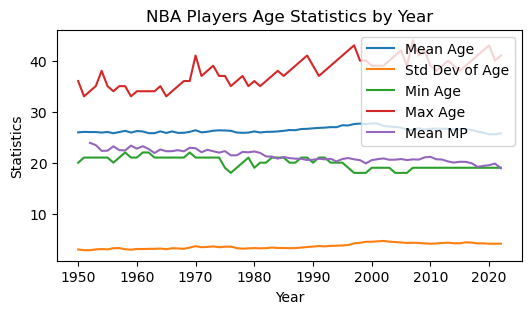

In [10]:
# NBA Age Plotting
pandas_df_each_year = df_each_year.toPandas()
plt.figure(figsize=(6, 3))

# Plot each column
plt.plot(pandas_df_each_year['Year'], pandas_df_each_year['mean'], label='Mean Age')
plt.plot(pandas_df_each_year['Year'], pandas_df_each_year['stddev'], label='Std Dev of Age')
plt.plot(pandas_df_each_year['Year'], pandas_df_each_year['min'], label='Min Age')
plt.plot(pandas_df_each_year['Year'], pandas_df_each_year['max'], label='Max Age')
plt.plot(pandas_df_each_year['Year'], pandas_df_each_year['mean_MP'], label='Mean MP')

# Adding title and labels
plt.title('NBA Players Age Statistics by Year')
plt.xlabel('Year')
plt.ylabel('Statistics')

# Show legend
plt.legend()

# Show the plot
plt.show()

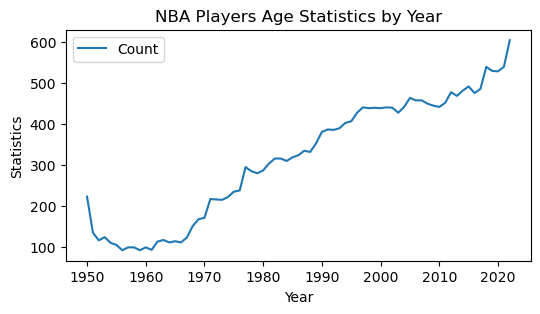

In [11]:
# Number of Players plotting
plt.figure(figsize=(6, 3))

# Plot each column
plt.plot(pandas_df_each_year['Year'], pandas_df_each_year['count'], label='Count')

# Adding title and labels
plt.title('NBA Players Age Statistics by Year')
plt.xlabel('Year')
plt.ylabel('Statistics')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [12]:
total_count = df_each_year.agg(F.sum("count").alias("total_count")).collect()[0]['total_count']
num_of_players = final_df.select("Player").distinct().count()
avg_season = total_count / num_of_players
print("Average season played by player:",avg_season)

Average season played by player: 5.1365864527629235


In [13]:
# Add a new column for the decade
df_with_decade = final_df.withColumn("Decade", (F.col("Year") / 10).cast("int") * 10)

# Group by the decade and calculate aggregates
df_each_decade = df_with_decade.groupBy("Decade").agg(
    F.count("Year").alias("count"),
    F.mean("Age").alias("mean"),
    F.stddev("Age").alias("stddev"),
    F.min("Age").alias("min"),
    F.max("Age").alias("max"),
    F.mean("MP").alias("mean_MP")
).orderBy(F.asc("Decade"))

df_each_decade.show()

+------+-----+------------------+------------------+---+---+------------------+
|Decade|count|              mean|            stddev|min|max|           mean_MP|
+------+-----+------------------+------------------+---+---+------------------+
|  1950| 1195|25.981589958158995|3.0052431818645955| 20| 38| 22.94193548387095|
|  1960| 1200|25.960833333333333|3.1531864507007756| 21| 36|22.514416666666676|
|  1970| 2374|26.094355518112888|3.4078603497622955| 18| 41|22.047430497051376|
|  1980| 3196|26.258760951188986| 3.306133376150644| 19| 41|21.113767209011304|
|  1990| 4102|27.194295465626524| 3.921695962602258| 18| 43| 20.56045831301809|
|  2000| 4465|  26.9511758118701| 4.425441585578973| 18| 44| 20.66676371780517|
|  2010| 4847| 26.44584278935424|  4.23854173221468| 19| 42|20.115741695894357|
|  2020| 1674|25.628434886499402|  4.11511628122598| 19| 43|19.395698924731168|
+------+-----+------------------+------------------+---+---+------------------+



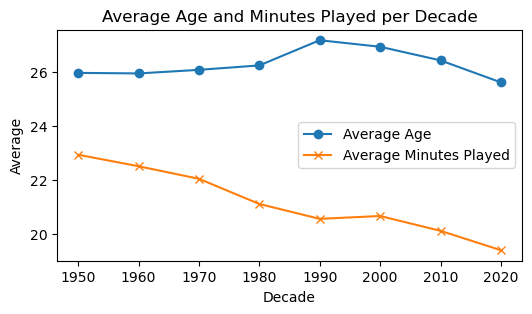

In [14]:
pandas_df_each_decade = df_each_decade.toPandas()
# Plotting
plt.figure(figsize=(6, 3))

# Plotting average age
plt.plot(pandas_df_each_decade['Decade'], pandas_df_each_decade['mean'], label='Average Age', marker='o')

# Plotting average minutes played
plt.plot(pandas_df_each_decade['Decade'], pandas_df_each_decade['mean_MP'], label='Average Minutes Played', marker='x')

# Adding title and labels
plt.title('Average Age and Minutes Played per Decade')
plt.xlabel('Decade')
plt.ylabel('Average')

# Show legend
plt.legend()

# Show the plot
plt.show()

In [15]:
# Define the age group based on the age
age_group_expr = F\
    .when(F.col("Age") <= 22, "19-22")\
    .when((F.col("Age") >= 23) & (F.col("Age") <= 25), "23-25")\
    .when((F.col("Age") >= 26) & (F.col("Age") <= 28), "26-28")\
    .when((F.col("Age") >= 29) & (F.col("Age") <= 31), "29-31")\
    .when((F.col("Age") >= 32) & (F.col("Age") <= 34), "32-34")\
    .otherwise("35+")

In [16]:
df_with_age_group = df_with_decade.withColumn("Age_Group", age_group_expr)
df_with_age_group.show(6)

+---+---------------+---+---+---+---+----+----+---+----+-----+----+----+----+---+----+-----+-----+---+---+-----+----+----+----+---+----+----+----+---+----+----+------+---------+
| Rk|         Player|Pos|Age| Tm|  G|  GS|  MP| FG| FGA|  FG%|  3P| 3PA| 3P%| 2P| 2PA|  2P%| eFG%| FT|FTA|  FT%| ORB| DRB| TRB|AST| STL| BLK| TOV| PF| PTS|Year|Decade|Age_Group|
+---+---------------+---+---+---+---+----+----+---+----+-----+----+----+----+---+----+-----+-----+---+---+-----+----+----+----+---+----+----+----+---+----+----+------+---------+
|  1|Curly Armstrong|G-F| 31|FTW| 63|null|null|2.3| 8.2|0.279|null|null|null|2.3| 8.2|0.279|0.279|2.7|3.8|0.705|null|null|null|2.8|null|null|null|3.4| 7.3|1950|  1950|    29-31|
|  2|   Cliff Barker| SG| 29|INO| 49|null|null|2.1| 5.6|0.372|null|null|null|2.1| 5.6|0.372|0.372|1.5|2.2|0.708|null|null|null|2.2|null|null|null|2.0| 5.7|1950|  1950|    29-31|
|  3|  Leo Barnhorst| SF| 25|CHS| 67|null|null|2.6| 7.4|0.349|null|null|null|2.6| 7.4|0.349|0.349|1.3|1.9|0.69

In [18]:
df_grouped = df_with_age_group.groupBy("Decade", "Age_Group").count().orderBy(F.asc("Decade"), F.asc("Age_Group"))
df_grouped.show(6)

+------+---------+-----+
|Decade|Age_Group|count|
+------+---------+-----+
|  1950|    19-22|  147|
|  1950|    23-25|  434|
|  1950|    26-28|  364|
|  1950|    29-31|  190|
|  1950|    32-34|   52|
|  1950|      35+|    8|
+------+---------+-----+
only showing top 6 rows



In [21]:
# Filter data from 1980 onwards
df_filtered = final_df.filter(df.Year >= 1980)
df_filtered.show(5)

+---+--------------------+---+---+---+---+----+----+----+----+-----+---+---+-----+----+----+-----+-----+---+---+-----+---+---+----+---+---+---+---+---+----+----+
| Rk|              Player|Pos|Age| Tm|  G|  GS|  MP|  FG| FGA|  FG%| 3P|3PA|  3P%|  2P| 2PA|  2P%| eFG%| FT|FTA|  FT%|ORB|DRB| TRB|AST|STL|BLK|TOV| PF| PTS|Year|
+---+--------------------+---+---+---+---+----+----+----+----+-----+---+---+-----+----+----+-----+-----+---+---+-----+---+---+----+---+---+---+---+---+----+----+
|  1|Kareem Abdul-Jabbar*|  C| 32|LAL| 82|null|38.3|10.2|16.9|0.604|0.0|0.0|  0.0|10.2|16.9|0.604|0.604|4.4|5.8|0.765|2.3|8.5|10.8|4.5|1.0|3.4|3.6|2.6|24.8|1980|
|  2|       Tom Abernethy| PF| 25|GSW| 67|null|18.2| 2.3| 4.7|0.481|0.0|0.0|  0.0| 2.3| 4.7|0.483|0.481|0.8|1.2|0.683|0.9|1.9| 2.9|1.3|0.5|0.2|0.6|1.8| 5.4|1980|
|  3|         Alvan Adams|  C| 25|PHO| 75|null|28.9| 6.2|11.7|0.531|0.0|0.0|  0.0| 6.2|11.6|0.533|0.531|2.5|3.1|0.797|2.1|6.0| 8.1|4.3|1.4|0.7|2.9|3.2|14.9|1980|
|  4|     Tiny Archibald*| P

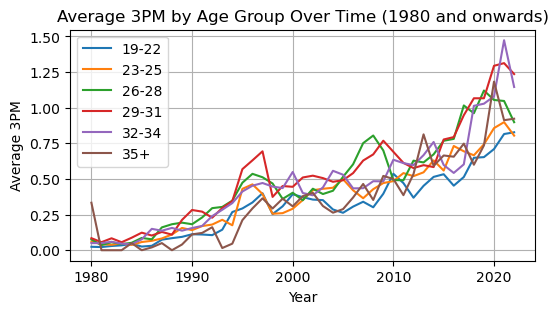

In [22]:
# Add a new column with age categories
df_with_age_category = df_filtered.withColumn("Age_Group", age_group_expr)

# Group by Age_Category and Year, and calculate average 3PM
df_grouped = df_with_age_category.groupBy("Age_Group", "Year").agg(F.avg("3P").alias("Avg_3PM")).orderBy(F.asc("Year"), F.asc("Age_Group"))

# Convert to Pandas DataFrame for plotting
pandas_df = df_grouped.toPandas()

# Plotting
plt.figure(figsize=(6, 3))
for age_group in pandas_df['Age_Group'].unique():
    subset = pandas_df[pandas_df['Age_Group'] == age_group]
    plt.plot(subset['Year'], subset['Avg_3PM'], label=age_group)

plt.xlabel('Year')
plt.ylabel('Average 3PM')
plt.title('Average 3PM by Age Group Over Time (1980 and onwards)')
plt.legend()
plt.grid(True)
plt.show()

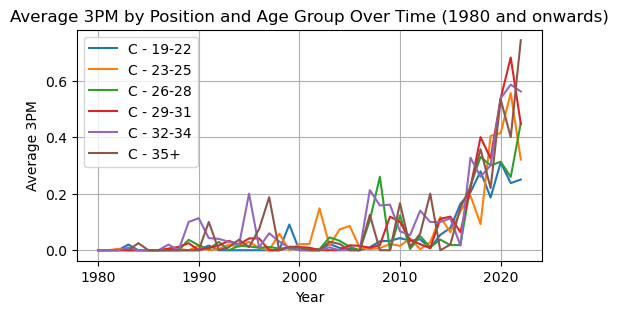

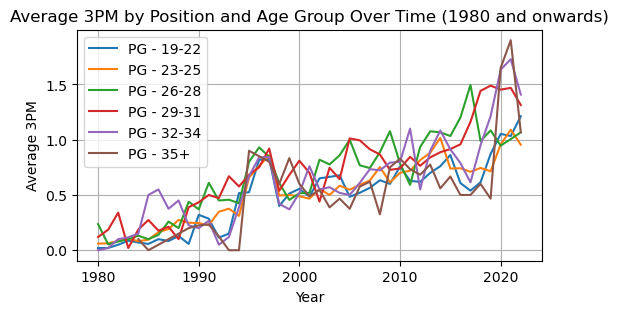

In [23]:
# Add a new column with age categories
df_with_age_category_position = df_filtered.withColumn("Age_Group", age_group_expr)

# Group by Position, Age_Group and Year, and calculate average 3PM
df_grouped_temp = df_with_age_category_position.groupBy("POS", "Age_Group", "Year").agg(F.avg("3P").alias("Avg_3PM")).orderBy("Year", "POS", "Age_Group")
df_grouped = df_grouped_temp.filter(df_grouped_temp["POS"] == "C")
df_grouped2 = df_grouped_temp.filter(df_grouped_temp["POS"] == "PG")

# Convert to Pandas DataFrame for plotting
pandas_df = df_grouped.toPandas()
pandas_df2 = df_grouped2.toPandas()

# Plotting
plt.figure(figsize=(6, 3))
for position in pandas_df['POS'].unique():
    for age_group in pandas_df['Age_Group'].unique():
        subset = pandas_df[(pandas_df['POS'] == position) & (pandas_df['Age_Group'] == age_group)]
        plt.plot(subset['Year'], subset['Avg_3PM'], label=f"{position} - {age_group}")

plt.xlabel('Year')
plt.ylabel('Average 3PM')
plt.title('Average 3PM by Position and Age Group Over Time (1980 and onwards)')
plt.legend()
plt.grid(True)
plt.show()

# Plotting
plt.figure(figsize=(6, 3))
for position in pandas_df2['POS'].unique():
    for age_group in pandas_df2['Age_Group'].unique():
        subset = pandas_df2[(pandas_df2['POS'] == position) & (pandas_df2['Age_Group'] == age_group)]
        plt.plot(subset['Year'], subset['Avg_3PM'], label=f"{position} - {age_group}")

plt.xlabel('Year')
plt.ylabel('Average 3PM')
plt.title('Average 3PM by Position and Age Group Over Time (1980 and onwards)')
plt.legend()
plt.grid(True)
plt.show()